# Projekt - Prepoznavanje raka pluća i debelog crijeva na slikama koristeći CNN


Prije svega, potrebno je učitati sve potrebne importe.

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.applications import ResNet50

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Prije nego što krenemo učiti modele, potrebno je učitati skup podataka.

In [2]:
# data_folder = '/kaggle/input/neumre/data'
data_folder = './data'

file_paths = []
labels = []

class_folders = os.listdir(data_folder)
for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    class_files = os.listdir(class_folder_path)

    for file in class_files:
        file_path = os.path.join(class_folder_path, file)
        
        file_paths.append(file_path)
        
        if class_folder == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif class_folder == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif class_folder == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif class_folder == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif class_folder == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

file_series = pd.Series(file_paths, name= 'filepath')
label_series = pd.Series(labels, name='label')
data = pd.concat([file_series, label_series], axis=1)

print(data.describe())

                                                 filepath  \
count                                               25000   
unique                                              25000   
top     /kaggle/input/neumre/data/colon_aca/colonca637...   
freq                                                    1   

                       label  
count                  25000  
unique                     5  
top     Colon Adenocarcinoma  
freq                    5000  


Možemo vizualizirati nekoliko slika kako bismo potvrdili da je učitavanje uspješno.

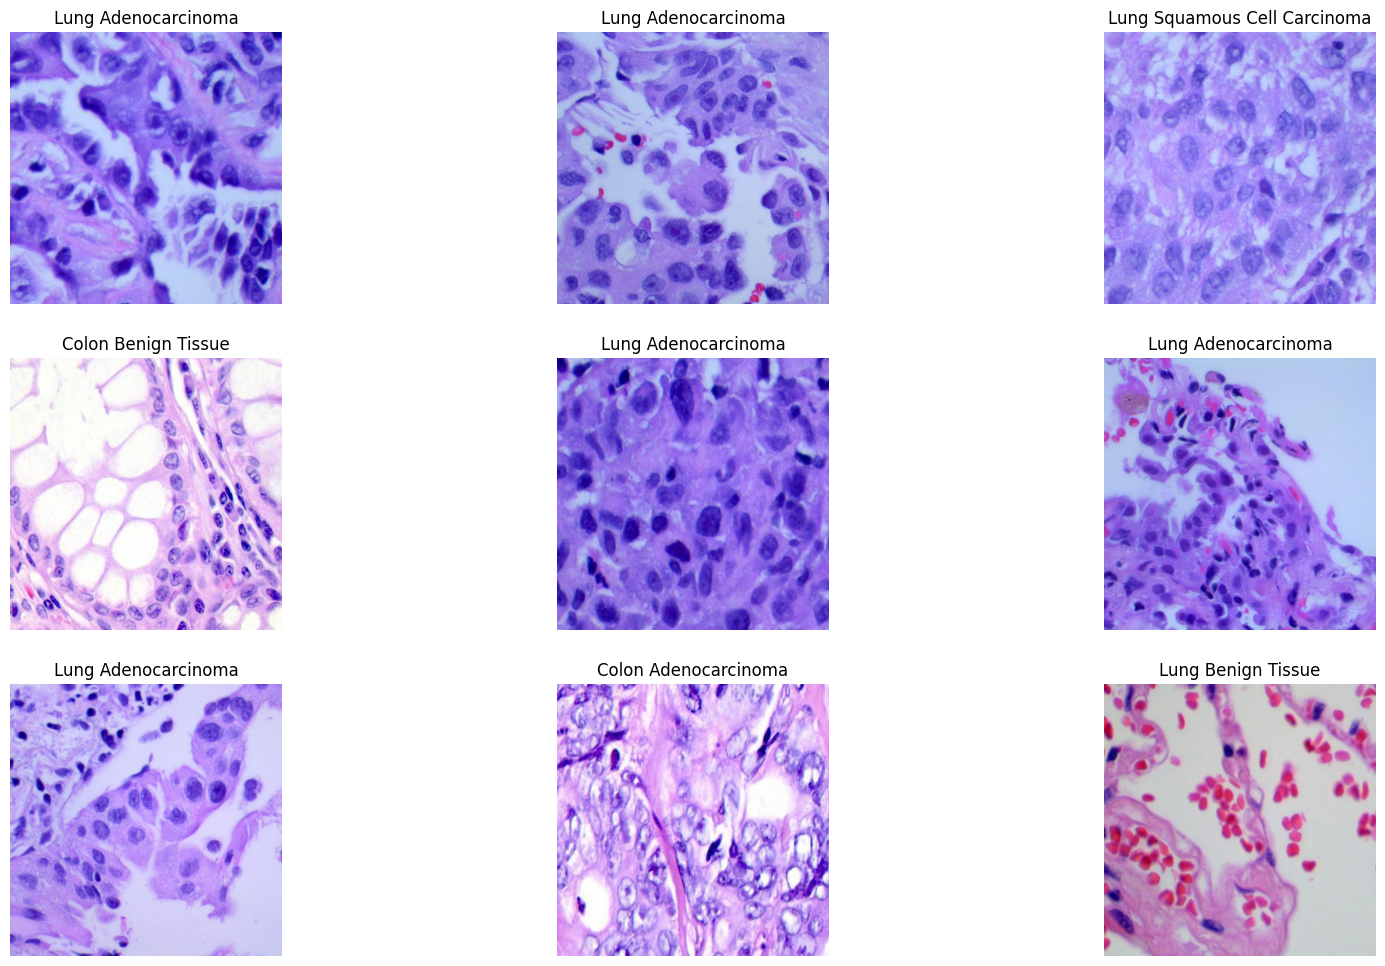

In [3]:
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(20,12))

for i in range(num_images):
    row_num = np.random.randint(0, data.shape[0])
    row = data.iloc[[row_num]]
    img = mpimg.imread(row['filepath'].item())

    plt.subplot(num_rows, num_cols, i + 1)
    plt.gca().set_title(row['label'].item())
    plt.gca().axis('off')
    plt.imshow(img)

plt.show()

Sljedeći korak je podijeliti skup podataka na tri disjunktna skupa: skup za učenje, ispitivanje i validaciju. 

In [4]:
train_data, temp_data = train_test_split(data, train_size=0.8, shuffle=True, random_state=100)
validation_data, test_data = train_test_split(temp_data,  train_size=0.5, shuffle=True, random_state=100)

Kada imamo sva tri skupa, potrebno je kreirati generatore koji će dohvaćati mini-grupe iz skupova, kao i obavljati dodatne poslove poput miješanja (shuffle) podataka. Kao veličinu mini-grupe stavit ćemo 16. Naravno, ovu veličinu možemo po volji podešavati.

In [5]:
batch_size = 16
image_size = (224, 224)
num_channels = 3

image_shape = (image_size[0], image_size[1], num_channels)
num_classes = 5

train_generator = ImageDataGenerator().flow_from_dataframe(train_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                           color_mode='rgb', shuffle=True, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow_from_dataframe(validation_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                                color_mode='rgb', shuffle=False, batch_size=batch_size)
test_generator = ImageDataGenerator().flow_from_dataframe(test_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


Sljedeći korak nam je odabrati model. Kao prvi model odabrat ćemo ResNet50 model s težinama naučenim na ImageNet skupu. Ovaj model prilagodit ćemo našem problemu - na izlaz ćemo dodati nekoliko potpuno-povezanih slojeva (kao i sloj za normalizaciju te dropout sloj), od kojih će posljednji sloj imati broj izlaza jednak broju razreda. Tada će predikcija modela odgovarati izlazu s najvećom vrijednošću (aktivacijska funkcija u posljednjem sloju bit će softmax).

In [6]:
pretrained_model = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
], name='ResNet50')

model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285

Sada možemo naučiti model, pritom koristeći skupove podataka za učenje i validaciju. Potrebno je odrediti broj epoha. Za početak ćemo isprobati učenje modela s ukupno 10 epoha. Pritom ćemo dodatno dodati dva callback-a: jedan za pohranu težina modela, a drugi za pohranu ispisa učenja u CSV formatu. Na kraju učenja, statistike modela (točnost, gubitak kroz epohe, itd.) ćemo pohraniti u zasebnu datoteku.

In [7]:
num_epochs = 10

if not os.path.exists('./models'): 
    os.makedirs('./models')
    
if not os.path.exists('./stats'): 
    os.makedirs('./stats')

checkpoint_saver = ModelCheckpoint(
    filepath=f'./models/{model.name}',
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
)

log_saver = CSVLogger(f'./stats/{model.name}_logs.csv')

stats = model.fit(x=train_generator, epochs=num_epochs, validation_data=validation_generator, verbose=1, callbacks=[checkpoint_saver, log_saver])

with open(f'./stats/{model.name}_stats.txt', 'wb') as file:
    pickle.dump(stats, file)

Epoch 1/10
1250/1250 [==============================] - 182s 136ms/step - loss: 0.9075 - accuracy: 0.9158 - val_loss: 0.1210 - val_accuracy: 0.9704
Epoch 2/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.3312 - accuracy: 0.9443 - val_loss: 0.0811 - val_accuracy: 0.9844
Epoch 3/10
1250/1250 [==============================] - 107s 86ms/step - loss: 0.2432 - accuracy: 0.9539 - val_loss: 0.1368 - val_accuracy: 0.9820
Epoch 4/10
1250/1250 [==============================] - 109s 88ms/step - loss: 0.2474 - accuracy: 0.9553 - val_loss: 0.0598 - val_accuracy: 0.9852
Epoch 5/10
1250/1250 [==============================] - 106s 85ms/step - loss: 0.1773 - accuracy: 0.9635 - val_loss: 0.0641 - val_accuracy: 0.9860
Epoch 6/10
1250/1250 [==============================] - 111s 89ms/step - loss: 0.2820 - accuracy: 0.9633 - val_loss: 0.1045 - val_accuracy: 0.9900
Epoch 7/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.2172 - accuracy: 0.9666 - val_loss: 